In [1]:
import os
import tempfile
import subprocess
from datetime import datetime
import shutil
from pathlib import Path

from concurrent.futures import as_completed, ProcessPoolExecutor
from collections.abc import Mapping

import numpy as np
import pandas as pd
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set(rc={'figure.figsize': (15, 10), 'figure.dpi' : 100})

import nevergrad as ng
from SALib.sample import saltelli
from SALib.analyze import sobol
import geotopy as gtp
from tqdm import tqdm

/home/max/.local/share/virtualenvs/MHPC-project-WaUKRq_w/lib/python3.8/site-packages/geotopy/__init__.py:35: RuntimeWarning: Default GEOTop executable not found, check your installation
  warnings.warn("Default GEOTop executable not found, check your installation",


In [2]:
# Defaults

# System settings
systmpfs = '/tmp'

# SA/Optimizer settings
num_workers = 2
budget = 16
SASampleN = 2
algorithm = 'OnePlusOne'
timeout = 60
target = 'soil_moisture_content_50'
params = {"NVanGenuchten": [1.15, 2.0, 1.5, "gaussian"],
          "AlphaVanGenuchten": [0.0005, 0.008, 0.002, "logarithmic"],
          "ThetaSat": [0.4, 0.7, 0.5, "gaussian"],
          "ThetaRes": [0.05, 0.08, 0.06, "gaussian"],
          "NormalHydrConductivity": [0.0001, 1.0, 0.01, "logarithmic"]}

In [3]:
outputs_tmpdir = tempfile.TemporaryDirectory(dir=systmpfs)
outputs_tmpdir_path = Path(outputs_tmpdir.name)

# High-Performance Derivative-Free Optimization for the GE🌍top Model Calibration

### Stefano Campanella

#### Giacomo Bertoldi, Alberto Sartori, Emanuele Cordano

## GEOtop Calibration

GEOtop is a physical model that simulates the heat and water budgets at and below the soil surface. 

Some inputs are unknown/uncertain: find the values such that the ouputs better reproduce the experimental data.

Case study: LTSER sites in Val di Mazia, Alto Adige

## Challenges

1. Many parameters 
2. No good prior
3. Time consuming simulations

<span class=fragment>**Parallel Derivative-free heuristic algorithms are the only option**</span>

Some points to keep in mind:

* Community of scientists, not HPC experts nor programmers
* Wide range of use cases and applications
* Calibration is CPU bounded
* For these algorithms, <span class="fragment highlight-red">scaling can be a tricky subject</span>

Consider genetic algorithms/PSO.

<span class=fragment>Increasing the number of phenotypes/particles increases the coverage of the parameters space in each generation/iteration, but the principle of operation of these algorithms lies in the correlation between one generation/iteration and the next.</span>

<span class=fragment>Hence, scaling must take into account that cutting the time to solution by increasing the number of processing units and decreasing the number of iterations can lead to worse results.</span>

## The Goal

1. Write a reusable calibration tool, with a simple yet general enough interface
2. Make it easily deployable on HPC systems
3. Perform the optimization and analysis on the case study
4. Benchmark algorithms, objective functions, and hyperparameters

## Constraints

1. 1D simulations
2. Only scalar parameters (however, the framework allows more complex scenarios) 
3. No multi-objective (multiple targets must be squashed into a single one)

## Approach/Design Choices

* Python: simple language, good tooling e wide adoption in scientific computing community.
* Do not reinvent the wheel (use standard libraries as much as possible, otherwise third party libraries).
* Modularity, encapsulation and referential transparency.
* Emphasis on documentation and reproducibility.

## What has been done

<ol>
    <li class=fragment>Preliminary analysis of the case study and visualization</li>
    <li class=fragment>GEOtoPy: A wrapper based on IO and keywords</li>
    <li class=fragment>Prototype of calibration with Nevergrad and SA with SALib</li>
    <li class=fragment>Deployment on Ulysses, now moving to VSC-4</li>
</ol>

## GEOtop IO scheme

## GEOtoPy

<img src="data/assets/geotopy.svg" height="800px">

In [4]:
class GEOtopExampleRun(gtp.GEOtop):

    def preprocess(self, working_dir, *args, **kwargs):
        
        settings = {**self, **kwargs}
        
        inpts_src_path = os.path.join(self.inputs_dir, 'geotop.inpts')
        inpts_dest_path = os.path.join(working_dir, 'geotop.inpts')
        
        with open(inpts_src_path, 'r') as inpts_src, open(inpts_dest_path, 'w') as inpts_dest:
            inpts_dest.write(f"! GEOtop input file written by GEOtoPy {datetime.now().strftime('%x %X')}\n")
            while line := inpts_src.readline():
                if gtp._comment_re.match(line):
                    inpts_dest.write(line)
                else:
                    try:
                        key, value = gtp.read_setting(line)
                        
                        if key in settings and value != settings[key]:
                            inpts_dest.write(f"! GEOtoPy: {key} overwritten, was {value}\n")
                            line = gtp.print_setting(key, settings[key])
                        else:
                            line = gtp.print_setting(key, value)
                        
                        inpts_dest.write(line)
                        del settings[key]
                    
                    except ValueError as err:
                        inpts_dest.write(f"! GEOtoPy: {err}\n")
                        inpts_dest.write(line)
            
            if settings:
                inpts_dest.write("\n! Settings added by GEOtoPy\n")
                for key, value in settings.items():
                    try:
                        line = gtp.print_setting(key, value)
                        inpts_dest.write(line)
                    except ValueError as err:
                        inpts_dest.write(f"! GEOtoPy: {err}\n")
                        inpts_dest.write(f"{key} = {value}\n")
                            
        
    def postprocess(self, working_dir):
        
        liq_path = os.path.join(working_dir, 'theta_liq.txt')
        liq = pd.read_csv(liq_path, 
                          na_values=['-9999'],
                          usecols=[0, 6, 7], 
                          skiprows=1,
                          header=0, 
                          names=['datetime', 'soil_moisture_content_50', 'soil_moisture_content_200'],
                          parse_dates=True, 
                          infer_datetime_format=True,
                          index_col=0)
        
        ice_path = os.path.join(working_dir, 'theta_ice.txt')
        ice = pd.read_csv(ice_path, 
                          na_values=['-9999'], 
                          usecols=[0, 6, 7], 
                          skiprows=1,
                          header=0, 
                          names=['datetime', 'soil_moisture_content_50', 'soil_moisture_content_200'],
                          parse_dates=True, 
                          infer_datetime_format=True,
                          index_col=0)
        
        sim = ice + liq
        
        return sim
    
    def save(self, destination, *args, **kwargs):
        
        shutil.copytree(self.inputs_dir, destination, dirs_exist_ok=True)
        model.preprocess(destination, *args, **kwargs)

In [5]:
class observations(Mapping):
    
    def __init__(self, path):
        
        self.data = pd.read_csv(path, 
                                na_values=['-9999'], 
                                parse_dates=True, 
                                infer_datetime_format=True,
                                index_col=0)
        
        self.data.index.rename('datetime', inplace=True)
        
        self.squared_mean = (self.data * self.data).mean()
        
    def __getitem__(self, key):
        
        return self.data[key]

    def __len__(self):
        
        return len(self.data)

    def __iter__(self):
        
        return iter(self.data)

    def compare(self, target, simulation, periods=None, name=None, unit=None, rel=False):

        if not periods:
            periods = {'Daily': 'D', 'Weekly': 'W', 'Monthly': 'M'}

        fig, axes = plt.subplots(ncols=3, 
                                 nrows=len(periods), 
                                 constrained_layout=True)

        if name:
            fig.suptitle(name)

        for i, (Tstr, T) in enumerate(periods.items()):
            comp_plot, diff_plot, hist_plot = axes[i, :]
            
            obs_resampled = self[target].resample(T).mean()
            sim_resampled = simulation[target].resample(T).mean()

            err = obs_resampled - sim_resampled        
            if rel:
                err = err / obs_resampled.abs()

            data = pd.DataFrame({'Observations': obs_resampled, 'Simulation': sim_resampled})
            sns.lineplot(data=data, ax=comp_plot)
            comp_plot.set_title(Tstr)
            comp_plot.set_xlabel("")
            if unit:
                comp_plot.set_ylabel(f'[{unit}]')

            sns.lineplot(data=err, ax=diff_plot)
            plt.setp(diff_plot.get_xticklabels(), rotation=20)
            if rel:
                diff_plot.set_ylabel(f'Relative error')
                diff_plot.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
            elif unit:
                diff_plot.set_ylabel(f'Error [{unit}]')
            else:
                diff_plot.set_ylabel(f'Error')

            sns.distplot(err, rug=True, vertical=True, hist=True, ax=hist_plot)
            y1, y2 = diff_plot.get_ylim()
            hist_plot.set_ylim(y1,y2)
            hist_plot.set_yticklabels([])
            hist_plot.set_ylabel("")
        
        return fig
    
    def metric(self, target, simulation):

        diff = (self[target] - simulation[target])
        diff_squared = diff * diff

        return np.sqrt(diff_squared.mean() / self.squared_mean[target])

In [6]:
model = GEOtopExampleRun('data/inputs/run',
                         exe='../../geotop/build/geotop',
                         run_args={'check': True, 
                                   'capture_output': True, 
                                   'timeout': timeout})

obs = observations('data/inputs/obs.csv')

/home/max/.local/share/virtualenvs/MHPC-project-WaUKRq_w/lib/python3.8/site-packages/geotopy/__init__.py:132: UserWarning: Unknown keyword HeaderAirPress. Skipping.
  warnings.warn(f"{err} Skipping.")
/home/max/.local/share/virtualenvs/MHPC-project-WaUKRq_w/lib/python3.8/site-packages/geotopy/__init__.py:132: UserWarning: Unknown keyword MaxTimesHalvingTimeStepWater. Skipping.
  warnings.warn(f"{err} Skipping.")
/home/max/.local/share/virtualenvs/MHPC-project-WaUKRq_w/lib/python3.8/site-packages/geotopy/__init__.py:132: UserWarning: Unknown keyword MaxTimesHalvingTimeStepEnergy. Skipping.
  warnings.warn(f"{err} Skipping.")
/home/max/.local/share/virtualenvs/MHPC-project-WaUKRq_w/lib/python3.8/site-packages/geotopy/__init__.py:132: UserWarning: Unknown keyword NumMaxSnowLayers. Skipping.
  warnings.warn(f"{err} Skipping.")
/home/max/.local/share/virtualenvs/MHPC-project-WaUKRq_w/lib/python3.8/site-packages/geotopy/__init__.py:132: UserWarning: Unknown keyword InfiniteSnowLayer. Skippin

Before optimization loss is 0.20770137763934485


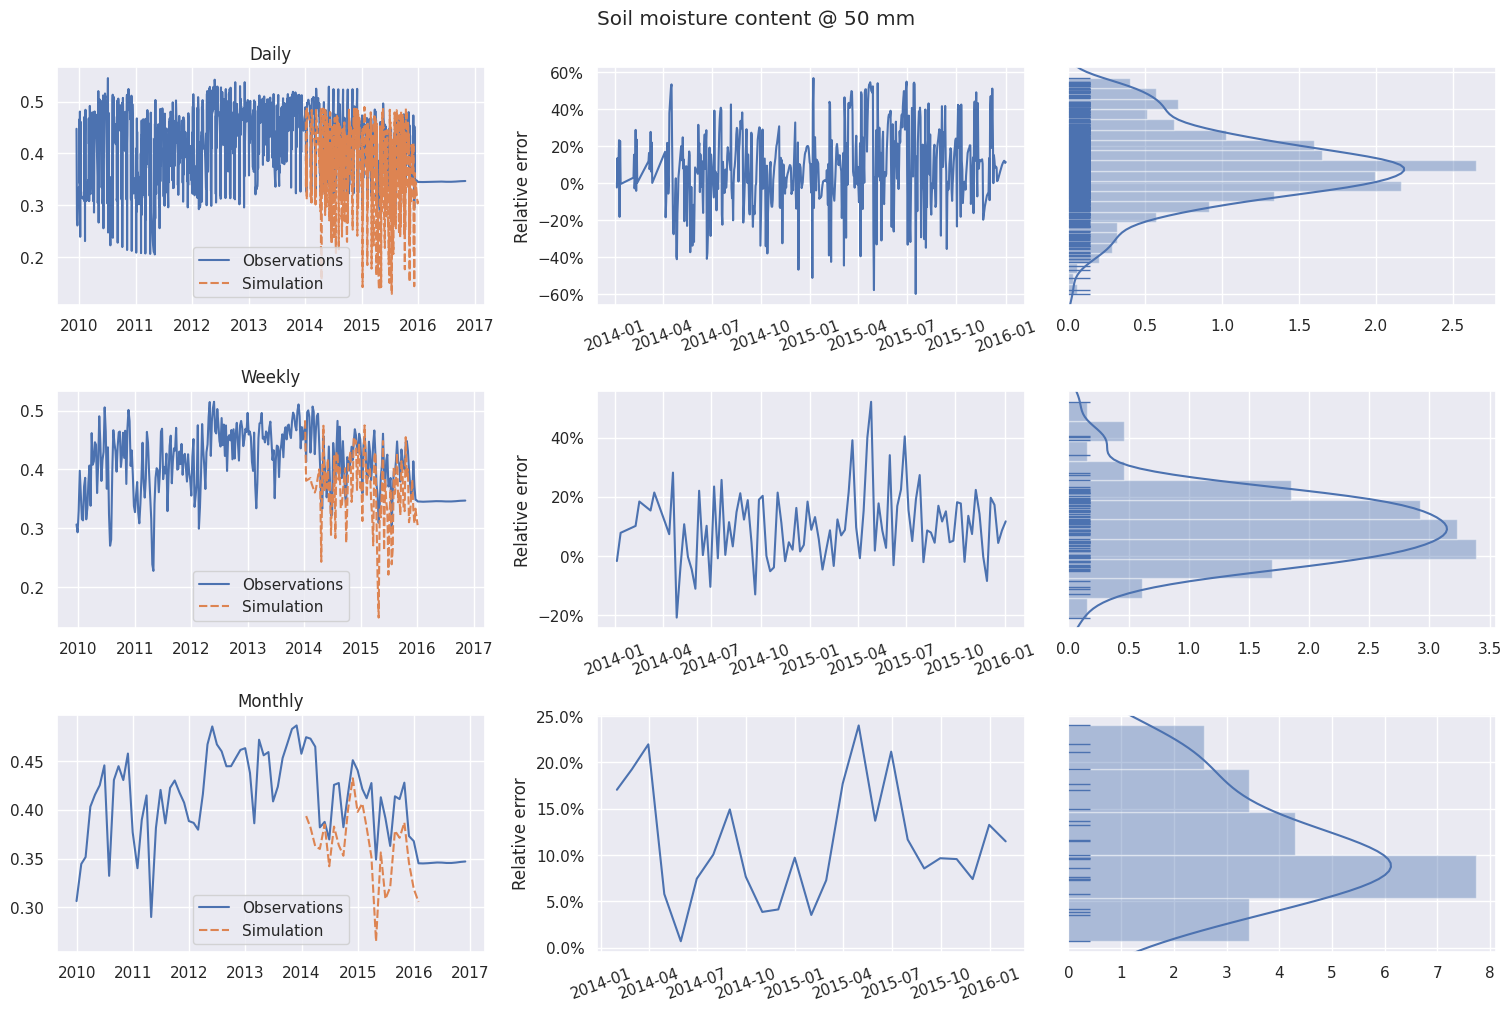

In [7]:
with tempfile.TemporaryDirectory(dir=systmpfs) as tmpdir:
    sim = model.eval(tmpdir)
    print(f"Before optimization loss is {obs.metric(target, sim)}")
    fig = obs.compare(target, sim, name="Soil moisture content @ 50 mm", rel=True)
    fig.savefig(outputs_tmpdir_path.joinpath('before_optimization.png'))
    plt.show()

## Example of Sensitivity Analysis

Right now, we are using the loss $\frac{\langle \left(y_\text{obs} - y_\text{sim} \right)^2 \rangle}{\langle y_\text{obs}^2 \rangle}$

In [8]:
def loss_function(*args, **kwargs): 
        
    with tempfile.TemporaryDirectory(dir=systmpfs) as tmpdir:
        try:
            sim = model.eval(tmpdir, *args, **kwargs)
        except subprocess.CalledProcessError:
            return np.nan
        except subprocess.TimeoutExpired:
            return np.nan

    return obs.metric(target, sim) # < (y_obs - y_sim)^2 > / < y_obs^2  >

In [9]:
def loss_SA_wrapper(xs):
    settings = {key: value for (key, value) in zip(params, xs)}
    return loss_function(**settings)

problem = {'num_vars': len(params),
           'names': [names for names in params],
           'bounds': [(a, b) for a, b, _, _ in params.values()]}

samples = saltelli.sample(problem, SASampleN, calc_second_order=False)

executor = ProcessPoolExecutor(max_workers=num_workers)
jobs = [executor.submit(loss_SA_wrapper, sample) for sample in samples]

losses = []
for job in tqdm(as_completed(jobs), total=len(jobs), position=0, leave=True):
    losses.append(job.result())

100%|██████████| 14/14 [01:19<00:00,  5.70s/it]


In [10]:
sa = sobol.analyze(problem, np.array(losses), calc_second_order=False);
sa_df = pd.DataFrame(sa, index=problem['names']);
sa_dfsort_values('S1', key=np.abs, ascending=False)

,S1,S1_conf,ST,ST_conf
NVanGenuchten,-0.249424,0.485081,1.133479,3.506960
AlphaVanGenuchten,0.003410,0.018796,0.000671,0.002317
ThetaSat,0.005952,0.359196,0.117719,0.252804
ThetaRes,0.005633,0.053882,0.001695,0.005292
NormalHydrConductivity,0.031159,0.158710,0.050741,0.177175


## Example of Calibration

In [11]:
dist = {'gaussian': ng.p.Scalar, 'logarithmic': ng.p.Log}

ng_params = {key: dist[t](lower=a, upper=b) for key, (a, b, _, t) in params.items()}


parameters = ng.p.Instrumentation(**ng_params)

optimizer = ng.optimizers.registry[algorithm](parametrization=parameters, 
                                              budget=budget, 
                                              num_workers=num_workers)

logger = ng.callbacks.ParametersLogger(outputs_tmpdir_path.joinpath('optimization_log'))
optimizer.register_callback("tell",  logger)

for sample, loss in zip(samples, losses):
    kwargs = dict(zip(problem['names'], sample))
    candidate = optimizer.parametrization.spawn_child(new_value=((), kwargs))
    optimizer.tell(candidate, loss)

progress_bar = ng.callbacks.ProgressBar()
optimizer.register_callback("tell",  progress_bar)

with ProcessPoolExecutor(max_workers=optimizer.num_workers) as executor:
    recommendation = optimizer.minimize(loss_function, 
                                        executor=executor, 
                                        batch_mode=False)

100%|██████████| 16/16 [01:20<00:00,  4.11s/it]

In [12]:
params_df = pd.DataFrame.from_dict(params, orient='index', columns=['lower', 'upper', 'suggested', 'distribution'])
params_df['best'] = pd.Series(recommendation.kwargs)

results = sa_df.join(params_df)
results.sort_values('S1', key=np.abs, ascending=False, inplace=True)

results

,S1,S1_conf,ST,ST_conf,lower,upper,suggested,distribution,best
NVanGenuchten,-0.249424,0.485081,1.133479,3.506960,1.1500,2.000,1.500,gaussian,1.295741
NormalHydrConductivity,0.031159,0.158710,0.050741,0.177175,0.0001,1.000,0.010,logarithmic,0.077226
ThetaSat,0.005952,0.359196,0.117719,0.252804,0.4000,0.700,0.500,gaussian,0.641189
ThetaRes,0.005633,0.053882,0.001695,0.005292,0.0500,0.080,0.060,gaussian,0.078412
AlphaVanGenuchten,0.003410,0.018796,0.000671,0.002317,0.0005,0.008,0.002,logarithmic,0.000582


In [13]:
logger.load()
hiplot_experiment = logger.to_hiplot_experiment()
hiplot_experiment.to_csv(outputs_tmpdir_path.joinpath('hiplot.csv'))

results.to_csv(outputs_tmpdir_path.joinpath('results.csv'), index=False)

model.save(outputs_tmpdir_path.joinpath('run_inpts'), **recommendation.kwargs)

After optimization loss is 0.15461835390789597


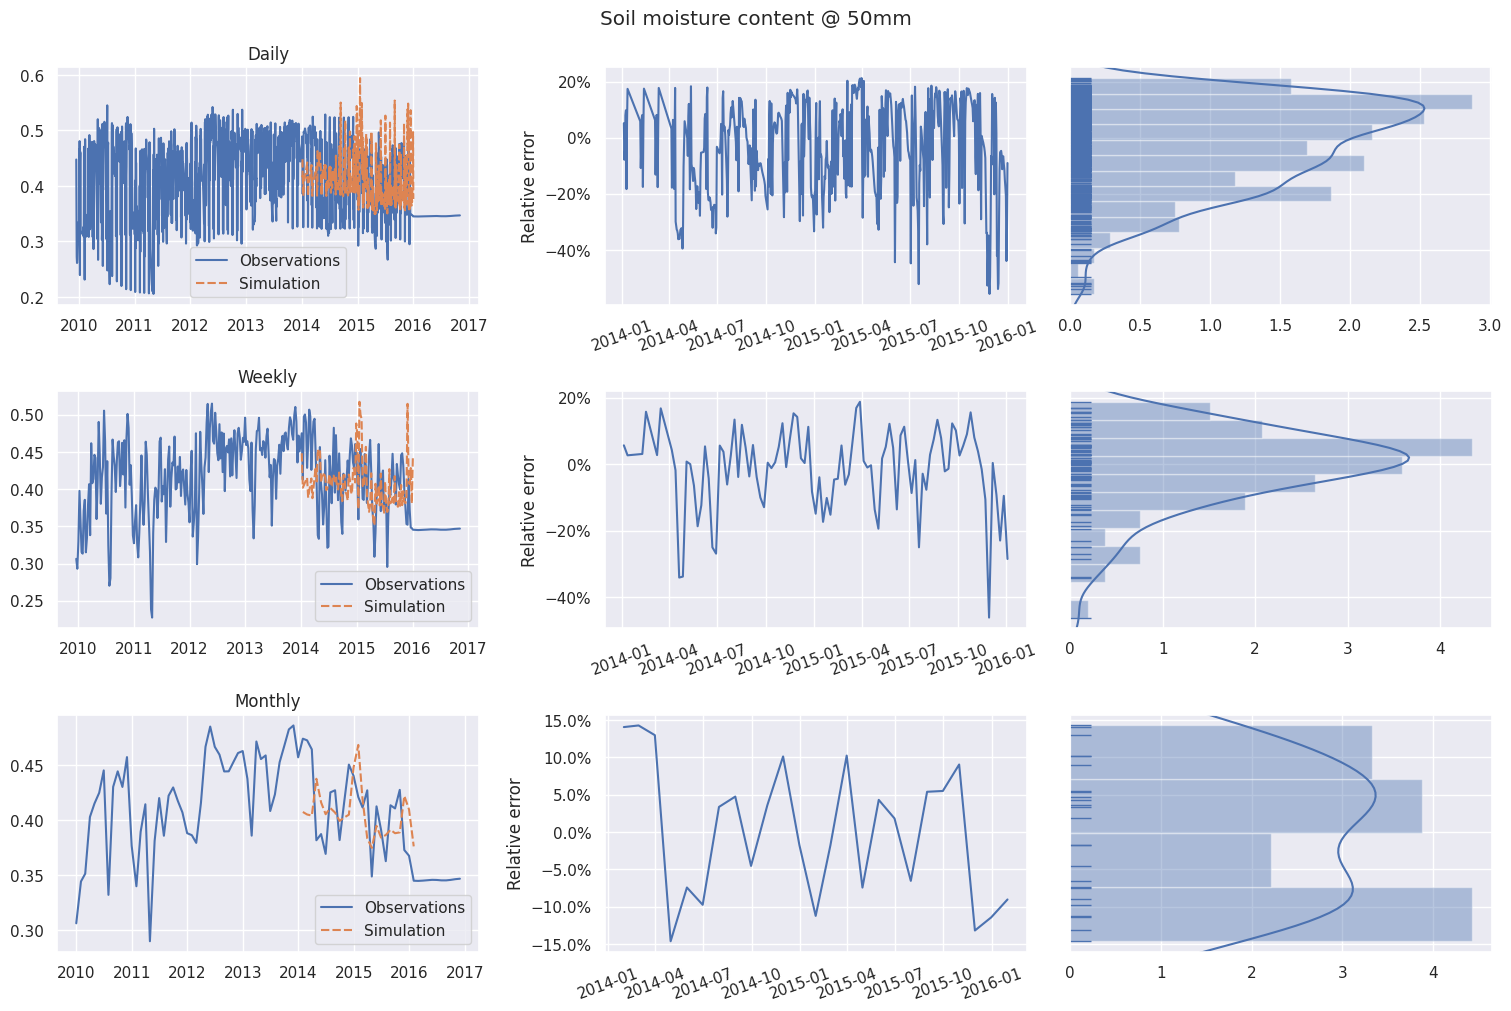

In [14]:
with tempfile.TemporaryDirectory() as tmpdir:
    print(f"After optimization loss is {recommendation.loss}")
    sim = model.eval(tmpdir, **recommendation.kwargs)
    fig = obs.compare(target, sim, name=f"Soil moisture content @ 50mm", rel=True)
    fig.savefig(outputs_tmpdir_path.joinpath('after_optimization.png'))
    plt.show()

In [15]:
basename = os.path.join('data/outputs', datetime.now().strftime('%Y-%m-%d_%H-%M'))
shutil.make_archive(basename, 'xztar', outputs_tmpdir_path)
outputs_tmpdir.cleanup()

## Deployment

1. SPACK
2. PyPi
3. Pipenv
4. Papermill

## To Do

1. Assemble the calibration package
2. Benchmarks

## Further developments

1. Ray Tune + Nevergrad (multinode)?
2. Multinode SA with Ray?
3. Inoculate information from SA into optimizer?
4. IO optimizations?
5. BFGS after global optimization?
6. Parameters clustering?